<a href="https://colab.research.google.com/github/SonAlexLe/Data-Project/blob/master/Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, pairwise_distances, davies_bouldin_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from pylab import rcParams
import collections

In [0]:
df_train_x = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/football_train_x.csv",delimiter = ',')
df_train_y = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/football_train_y.csv",delimiter = ',')
df_test_x = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/football_test_x.csv",delimiter = ',')
df_test_y = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/football_test_y.csv",delimiter = ',')

In [0]:
df_train_full = pd.concat([df_train_x,df_train_y],axis=1,join='outer')
df_train = df_train_full.drop(['Interest','FTG'],axis=1) # ,'HomeTeam','AwayTeam'
df_test_full = pd.concat([df_test_x,df_test_y],axis=1,join='outer')
df_test = df_test_full.drop(['Interest','FTG'],axis=1) # ,'HomeTeam','AwayTeam'
df_full_full = pd.concat([df_train_full,df_test_full],axis=0,join='outer',ignore_index=True)
# df_full_full.index=pd.Int64Index(range(1,1141))
df_full = df_full_full.drop(['Interest','FTG'],axis=1) # SHOULD NOT BE CHANGED, FOR DATA EXPLORATION. DROP 'FTG' AND 'INTEREST' TO PLOT PCA
true = df_test_y['Interest'] # TRUE LABELS
df_full_full

,HomeTeam,AwayTeam,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,Interest,FTG
0,19,8,2,1,1,18,6,7,2,8,10,5,4,1,5
1,24,16,2,0,1,12,8,6,3,12,13,5,1,0,3
2,3,12,0,0,0,13,8,4,4,8,8,0,11,1,4
3,2,20,0,0,0,7,6,2,2,10,10,2,6,0,0
4,24,9,0,1,-1,14,11,6,3,13,16,4,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,16,6,0,0,0,14,12,4,3,14,8,6,3,0,0
1136,5,2,0,1,-1,11,14,4,9,9,11,7,8,0,6
1137,24,0,0,1,-1,21,13,11,8,8,8,7,4,0,1
1138,9,0,0,0,0,8,13,2,6,9,13,2,1,1,2


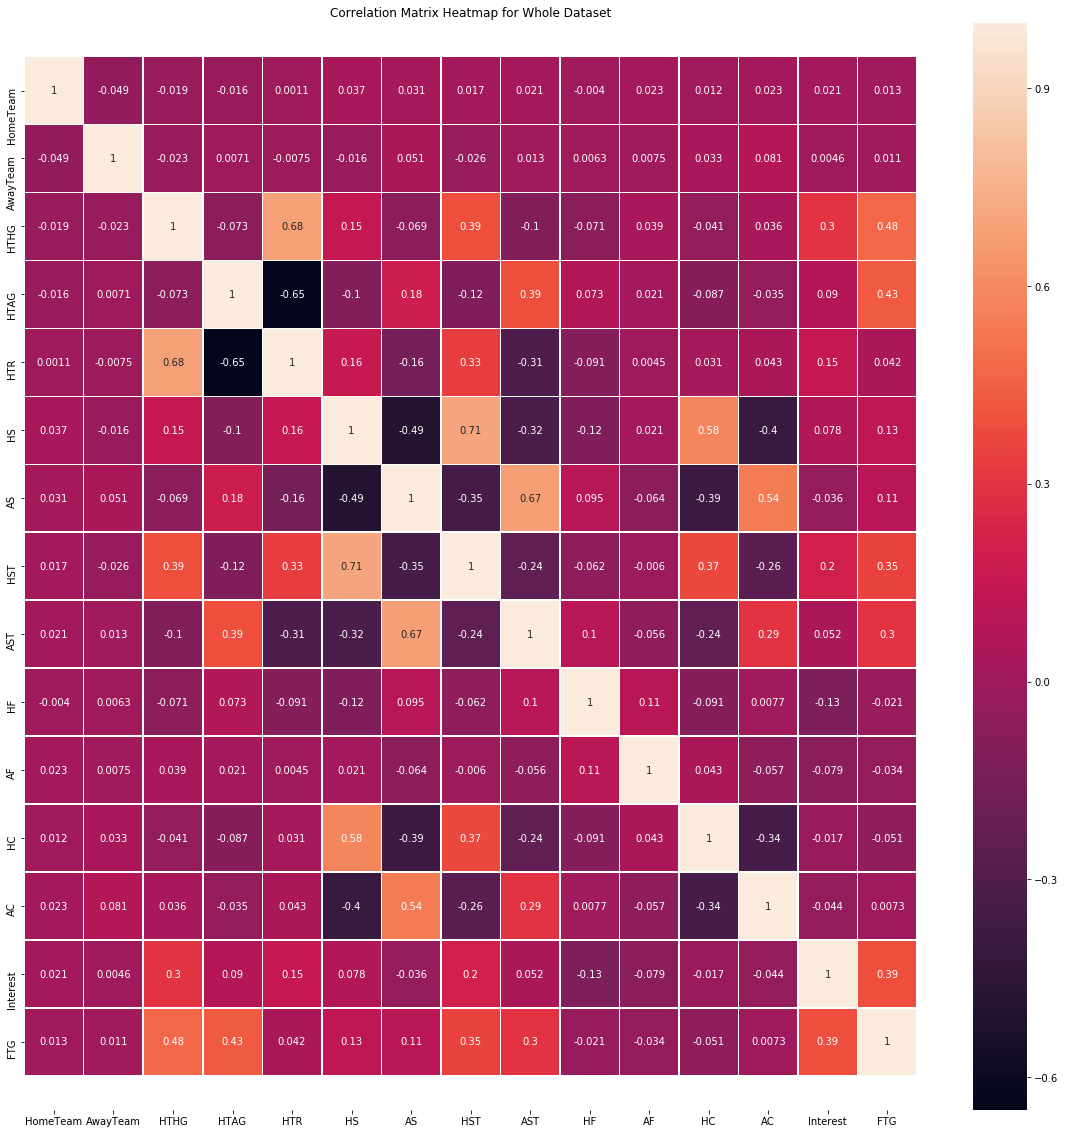

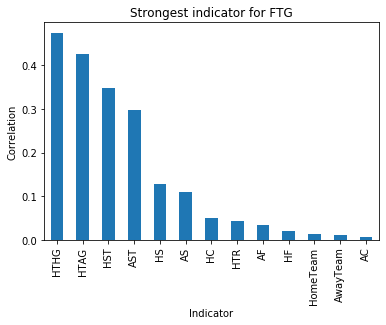

In [0]:
corr_mat = df_full_full.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(corr_mat,linewidth=0.5,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) # fix heatmap broken by matplotlib, IMPORTANT
plt.title('Correlation Matrix Heatmap for Whole Dataset')
plt.show()
#Using corr matrix to find out what is the strongest indicator for FTG.
df_full_full.drop(['Interest'],axis=1).corr()['FTG'].abs().sort_values(ascending=False).drop('FTG').plot(kind='bar')
plt.title('Strongest indicator for FTG')
plt.xlabel('Indicator')
plt.ylabel('Correlation')
plt.show()

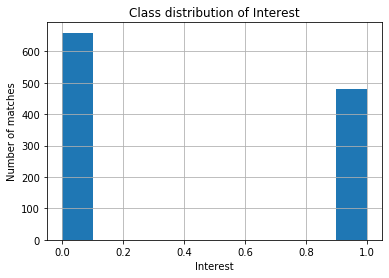

In [0]:
def histogram(label=None):
  df_full_full.hist(label)#, figsize=(20,12))
  plt.title(f'Class distribution of {label}')
  plt.xlabel(label)
  plt.ylabel('Number of matches')
  plt.show()
histogram('Interest')

In [0]:
def scale(df,kind='normal',return_df=False):
  """kind: normal, standard, minmax, maxabs, robust, power, normalizer"""
  if kind == 'standard':
    scaler = preprocessing.StandardScaler()
  elif kind == 'minmax':
    scaler = preprocessing.MinMaxScaler()
  elif kind == 'maxabs':
    scaler = preprocessing.MaxAbsScaler()
  elif kind == 'robust':
    scaler = preprocessing.RobustScaler()
  elif kind == 'power':
    scaler = preprocessing.PowerTransformer()
  elif kind == 'normalizer':
    scaler = preprocessing.Normalizer()
  if kind == 'normal':
    scaled_df = preprocessing.scale(df)
  else:
    scaled_df = scaler.fit_transform(df)
  orig_var = []
  orig_vars = []
  b = df.copy()
  for i in b.columns:
    orig_var.append(b[i].var())
  c = np.sum(np.array(orig_var))
  for i in range(b.columns.size):
    orig_vars.append(orig_var[i]/c)
  d = np.sort(orig_vars)[::-1]
  if return_df:
    e = pd.DataFrame(scaled_df,columns=df.columns)
    return e
  else:
    return scaled_df, d

In [0]:
a, b = scale(df_train,kind='minmax',return_df=False)
print(b)

[0.25055832 0.24349604 0.15426795 0.10481338 0.05320899 0.05315191
 0.04128179 0.03377784 0.03341695 0.02373165 0.00306977 0.00263301
 0.0025924 ]


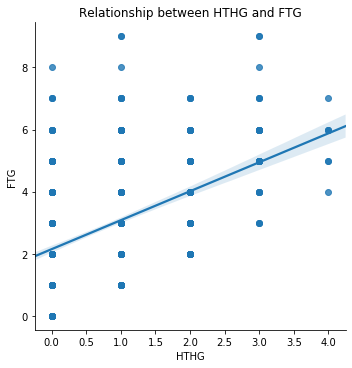

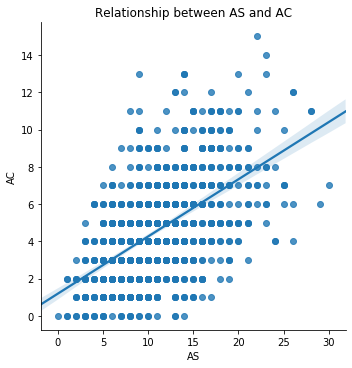

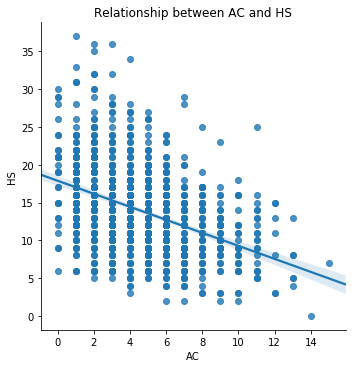

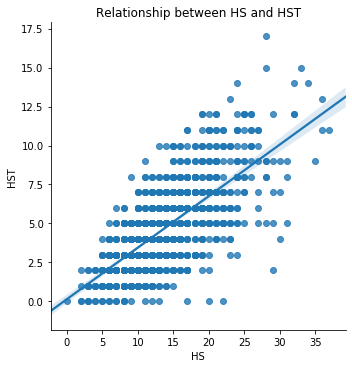

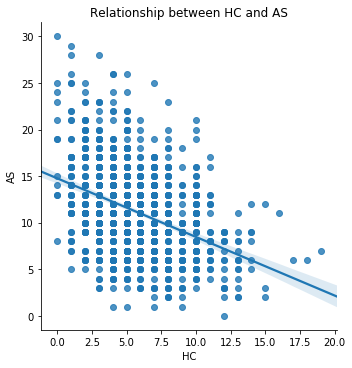

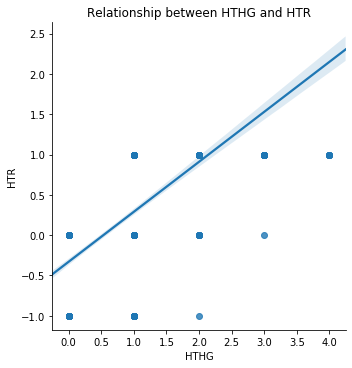

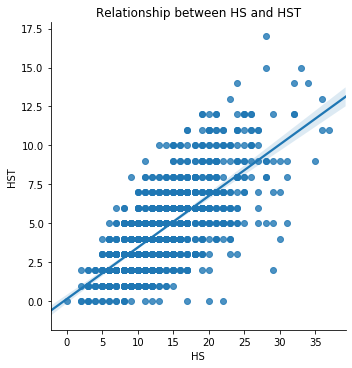

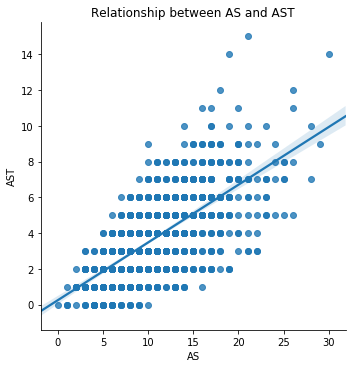

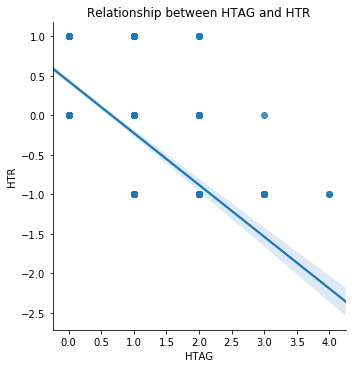

In [0]:
def pairplots(label1,label2):
  sns.lmplot(label1,label2,data=df_full_full)
  plt.title(f'Relationship between {label1} and {label2}')
  plt.show()
pairplots('HTHG','FTG')
pairplots('AS','AC')
pairplots('AC','HS')
pairplots('HS','HST')
pairplots('HC','AS')
pairplots('HTHG','HTR')
pairplots('HS','HST')
pairplots('AS','AST')
pairplots('HTAG','HTR')

In [0]:
def pcafun(df,count, pca_obj=None, show_plots=False,show_info=False, scaler='minmax'):
  scaled_df, orig_var = scale(df,kind=scaler)
  true = (pca_obj != None)
  if true:
    pca = pca_obj
  else:
    pca = PCA()
    pca.fit(scaled_df)
  pca_data=pca.transform(scaled_df)
  per_var = np.round(pca.explained_variance_ratio_* 100, decimals=2)
  retained_variance = pca.explained_variance_ratio_.cumsum()*100
  labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
  pca_df=pd.DataFrame(pca_data,columns=labels)
  orig_cumsum = orig_var.cumsum()*100
  if count == 0:
    pca_dat = pca_df.copy()
  else:
    pca_dat = pca_df.iloc[:,:-count] # PREPARES AND EXTRACTS A TRAIN PC DATAFRAME
  # original variance 
  if show_plots:
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot')
    plt.show()
    plt.plot(range(1,len(retained_variance)+1),retained_variance,marker='o',color='b',label='PCA explained variance')
    plt.plot(range(1,len(orig_var)+1),orig_cumsum,marker='o',color='red',label='Original explained variance')
    plt.legend()
    plt.xlabel('Number of Principal Components')
    plt.title('Cumulative Explained Variance')
    plt.show()
    plt.scatter(pca_df.PC1,pca_df.PC2)
    plt.xlabel('PC1-{0}%'.format(per_var[0]))
    plt.ylabel('PC2-{0}%'.format(per_var[1]))
    plt.title('PCA projection with first two principal components')
    plt.show()
  if show_info:
    print(f'Percentage of explained variance: {per_var}')
    print(f'Cumulative explained variance: {np.round(retained_variance,decimals=2)}')
    loading_scores = pd.Series(pca.components_[0], index=df.columns)
    ## now sort the loading scores based on their magnitude
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    # get the names of the top 10 variables
    top_5_vars = sorted_loading_scores[0:5].index.values
    ## print the variable names and their scores (and +/- sign)
    print('First 5 loading scores for PC1 of Whole Set')
    print(loading_scores[top_5_vars])
    loading_scores = pd.Series(pca.components_[1], index=df.columns)
    ## now sort the loading scores based on their magnitude
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    # get the names of the top 10 variables
    top_5_vars = sorted_loading_scores[0:5].index.values
    ## print the variable names and their scores (and +/- sign)
    print('-------------')
    print('First 5 loading scores for PC2 of Whole Set')
    print(loading_scores[top_5_vars])
    print('Raw explained variance ratios:')
    print(pca.explained_variance_ratio_* 100)
    print(f'Shape of the extracted dataset: {pca_dat.shape}')
    print(pca_dat)
  if true:
    return pca_dat
  else:
    return pca_dat, pca

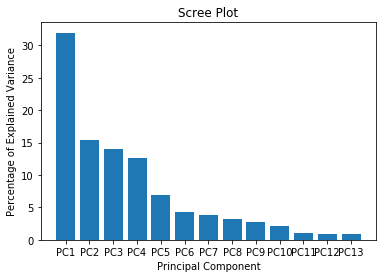

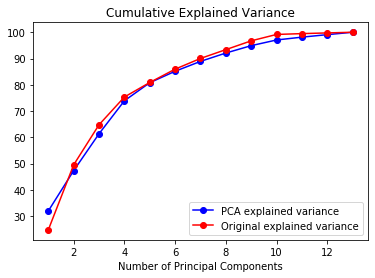

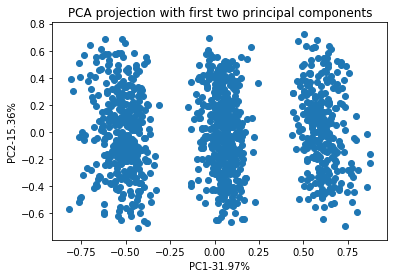

Percentage of explained variance: [31.97 15.36 14.03 12.56  6.88  4.36  3.76  3.18  2.81  2.16  1.07  0.95
  0.92]
Cumulative explained variance: [ 31.97  47.32  61.35  73.91  80.79  85.15  88.91  92.09  94.9   97.06
  98.13  99.08 100.  ]
First 5 loading scores for PC1 of Whole Set
HTR    -0.857008
HTHG   -0.339894
HTAG    0.283754
HST    -0.161055
AST     0.141916
dtype: float64
-------------
First 5 loading scores for PC2 of Whole Set
AwayTeam   -0.728670
HomeTeam    0.669880
AC         -0.084779
HS          0.065051
AS         -0.055647
dtype: float64
Raw explained variance ratios:
[31.96503489 15.35638337 14.03226464 12.56018957  6.87715468  4.35553009
  3.76254146  3.17937683  2.80724667  2.16249165  1.0741966   0.95194176
  0.91564778]
Shape of the extracted dataset: (1140, 3)
           PC1       PC2       PC3
0    -0.547510  0.311197 -0.029350
1    -0.568135  0.210176 -0.380882
2     0.068594 -0.278893  0.224745
3     0.077897 -0.516275  0.117452
4     0.535915  0.436917 -0.19

In [0]:
a,b = pcafun(df_full, 10, show_plots=True,show_info=True, scaler='minmax')

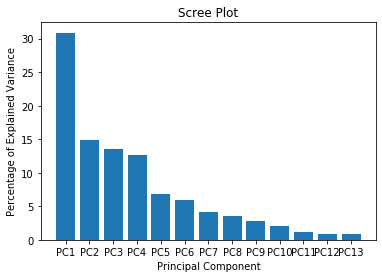

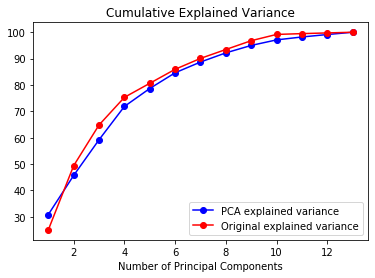

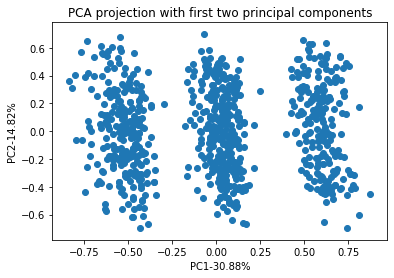

Percentage of explained variance: [30.88 14.82 13.52 12.64  6.8   5.96  4.08  3.48  2.82  2.1   1.1   0.93
  0.87]
Cumulative explained variance: [ 30.88  45.7   59.23  71.86  78.67  84.63  88.71  92.18  95.    97.1
  98.21  99.13 100.  ]
First 5 loading scores for PC1 of Whole Set
HTR    -0.853088
HTHG   -0.326026
HTAG    0.291368
HST    -0.165660
AST     0.153501
dtype: float64
-------------
First 5 loading scores for PC2 of Whole Set
AwayTeam   -0.808318
HomeTeam    0.543438
AC         -0.114688
HS          0.110497
AS         -0.082475
dtype: float64
Raw explained variance ratios:
[30.88014336 14.82456483 13.52336567 12.63690895  6.80325522  5.96232037
  4.07617331  3.47643355  2.81694901  2.1014052   1.10373275  0.92584874
  0.86889904]
Shape of the extracted dataset: (798, 3)
          PC1       PC2       PC3
0   -0.565226  0.296702 -0.038805
1   -0.593371  0.140452 -0.372237
2    0.069443 -0.260410  0.249681
3    0.075065 -0.504799  0.202849
4    0.502117  0.419785 -0.265298
.. 

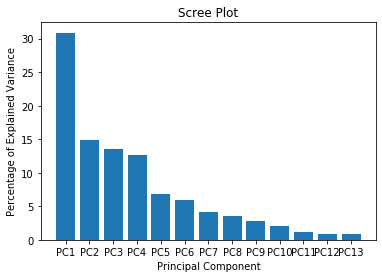

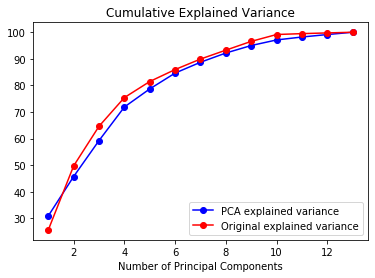

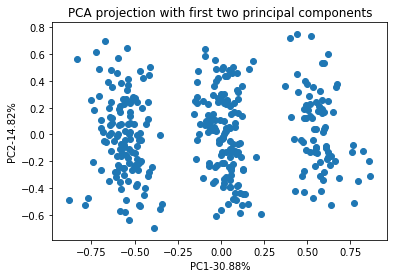

Percentage of explained variance: [30.88 14.82 13.52 12.64  6.8   5.96  4.08  3.48  2.82  2.1   1.1   0.93
  0.87]
Cumulative explained variance: [ 30.88  45.7   59.23  71.86  78.67  84.63  88.71  92.18  95.    97.1
  98.21  99.13 100.  ]
First 5 loading scores for PC1 of Whole Set
HTR    -0.853088
HTHG   -0.326026
HTAG    0.291368
HST    -0.165660
AST     0.153501
dtype: float64
-------------
First 5 loading scores for PC2 of Whole Set
AwayTeam   -0.808318
HomeTeam    0.543438
AC         -0.114688
HS          0.110497
AS         -0.082475
dtype: float64
Raw explained variance ratios:
[30.88014336 14.82456483 13.52336567 12.63690895  6.80325522  5.96232037
  4.07617331  3.47643355  2.81694901  2.1014052   1.10373275  0.92584874
  0.86889904]
Shape of the extracted dataset: (342, 3)
          PC1       PC2       PC3
0   -0.030764 -0.604804  0.241290
1    0.578933 -0.421025  0.112347
2    0.026786 -0.319246 -0.060322
3   -0.704807  0.485413  0.138277
4    0.530956  0.353378 -0.215523
.. 

In [0]:
pca_dat, pca = pcafun(df_train, count=10,show_plots=True,show_info=True, scaler='minmax')
pca_dat_test = pcafun(df_test, count=10, pca_obj=pca,show_plots=True,show_info=True,scaler='minmax')

In [0]:
# Generic K-nearest neighbor function
def knn(x_train, x_test, y_train, y_test,count,k=3,criterion='Accuracy',show_info=False, pca=True, scaler='minmax', pca_show=True):
  """count: number of principals to drop, starting from last
     k: number of nearest neighbors"""
  if pca:
    pca_dat, pca = pcafun(x_train, count,scaler=scaler)
    pca_dat_test = pcafun(x_test, count, pca_obj=pca,scaler=scaler)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(pca_dat,y_train)
    pred = neigh.predict(pca_dat_test)
    error = np.mean(pred != y_test)
  else:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train,y_train)
    pred = neigh.predict(x_test)
    error = np.mean(pred != y_test)
  if pca_show:
    print(f'Number of principal components used: {x_train.columns.size - count}')
    print(f'Principal component drop count: {count}')
  if show_info:
    cm = confusion_matrix(true,pred)
    ax = sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True,linewidths=0.5)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('KNN Confusion Matrix')
    plt.savefig('confusion.png')
    plt.show()
    print(classification_report(true,pred))
  if criterion == 'Mean error':
    return error
  else:
    return accuracy_score(y_test, pred) # imported at the beginning cell

In [0]:
# Tries to optimize the number of nearest neighbors
def knn_optimizer(x_train, x_test, y_train, y_test,count,criterion='Accuracy',show_info=False, pca=True, scaler='minmax', pca_show=True, category='best'):
  metrics = []
  for i in range(1,50):
    a = knn(x_train, x_test, y_train, y_test, count, k=i,criterion=criterion, pca=pca, scaler=scaler, pca_show=False)
    metrics.append(a)
  if criterion == 'Mean error' or category == 'worst':
    bestk = np.argmin(metrics) + 1
  else:
    bestk = np.argmax(metrics) + 1
  assess = np.round(metrics[bestk-1]*100,2)
  if show_info:
    print(f'When k = {bestk}, the {criterion} is the best, which is {assess}%.')
    plt.figure(figsize=(15,7))
    plt.plot([i for i in range(1,len(metrics)+1)],metrics,color='red',linewidth=1,marker='o')
    plt.ylabel(criterion)
    plt.xlabel('Number of nearest neighbors')
    plt.title(f'{criterion} k value')
    plt.savefig('neighbor_count.png')
    plt.show()
  b = knn(x_train, x_test, y_train, y_test, count, k=bestk,criterion=criterion,show_info=show_info, pca=pca,scaler=scaler,pca_show=pca_show)
  return b, bestk


In [0]:
# Tries to optimize the number of principal components to use, based on the best number of neighbors for each choice
def knn_optimizer_master(x_train, x_test, y_train, y_test,criterion='Accuracy', show_info=False, scaler='minmax', category='best'):
  metrics = []
  ks = []
  pc_count = []
  for i in range(x_train.columns.size):
    a, k = knn_optimizer(x_train, x_test, y_train, y_test, i,criterion=criterion,scaler=scaler, pca_show=False)
    metrics.append(a)
    ks.append(k)
    pc_count.append(i)
  if criterion == 'Mean error' or category == 'worst':
    best = np.argmin(metrics)
  else:
    best = np.argmax(metrics)
  bestk = ks[best]
  assess = np.round(metrics[best]*100,2)
  if show_info:
    plt.figure(figsize=(15,7))
    plt.plot([x_train.columns.size - i for i in pc_count],metrics,color='g',linewidth=1,marker='o')
    plt.xlabel('Number of principal components used')
    plt.ylabel(f'{criterion} of optimal k when this number of PC is used')
    plt.savefig('pc_count.png')
    plt.show()
  # print(f'When k = {bestk}, the {criterion} is the best, which is {assess}%.')
  # print([x_train.columns.size - i for i in pc_count])
  b = knn_optimizer(x_train, x_test, y_train, y_test,count=best,show_info=show_info,criterion=criterion,scaler=scaler)
  return b

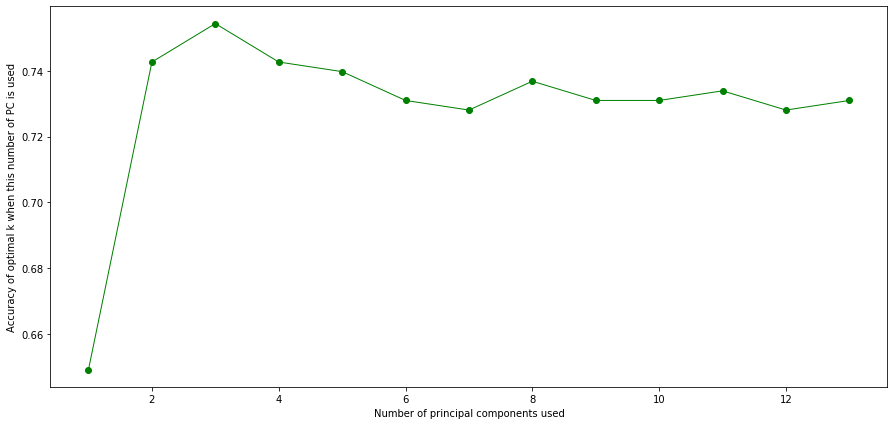

When k = 33, the Accuracy is the best, which is 75.44%.


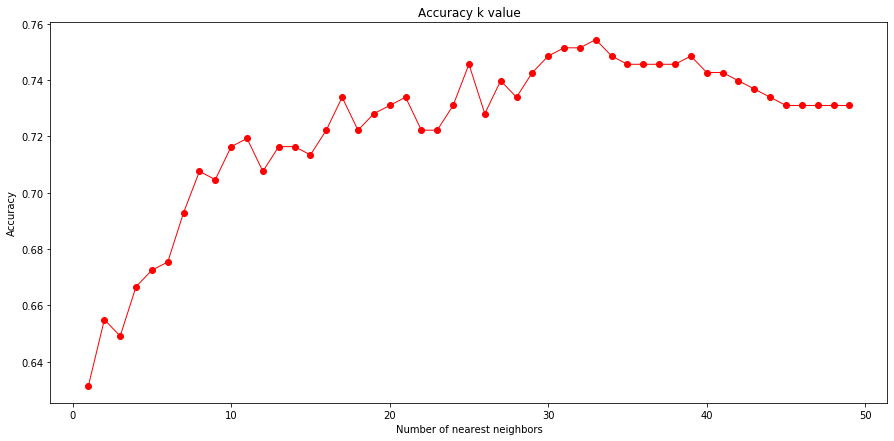

Number of principal components used: 3
Principal component drop count: 10


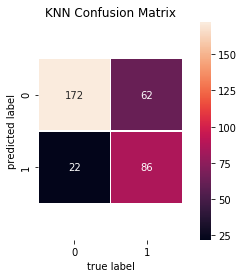

              precision    recall  f1-score   support

           0       0.74      0.89      0.80       194
           1       0.80      0.58      0.67       148

    accuracy                           0.75       342
   macro avg       0.77      0.73      0.74       342
weighted avg       0.76      0.75      0.75       342



In [0]:
standard = knn_optimizer_master(df_train,df_test,df_train_y['Interest'],df_test_y['Interest'], criterion='Accuracy',scaler='standard',show_info=True)
# minmax = knn_optimizer_master(df_train,df_test,df_train_y['Interest'],df_test_y['Interest'], criterion='Accuracy',scaler='minmax',show_info=True)
# print(standard[0] == minmax[0])

When k = 18, the Accuracy is the best, which is 73.68%.


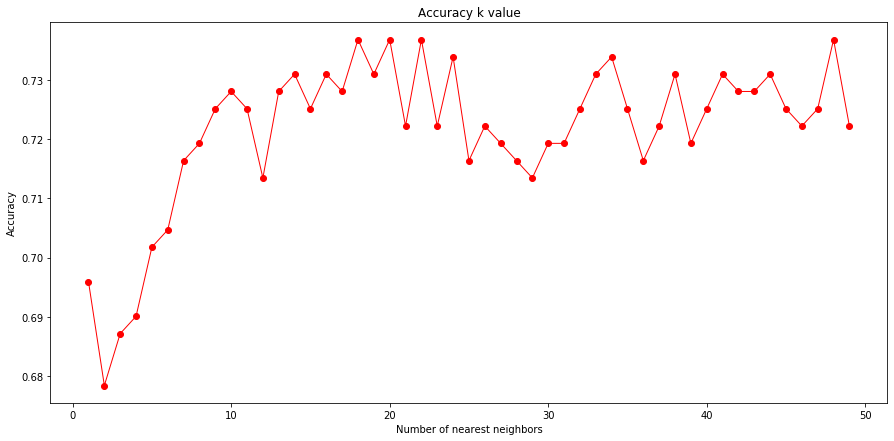

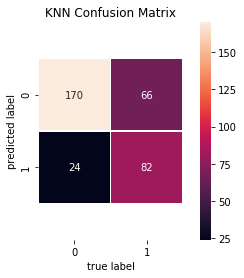

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       194
           1       0.77      0.55      0.65       148

    accuracy                           0.74       342
   macro avg       0.75      0.72      0.72       342
weighted avg       0.74      0.74      0.73       342



(0.7368421052631579, 18)

In [0]:
# KNN without PCA # scale(scale(df_train,'minmax',True),'standard',True)
knn_optimizer(scale(df_train,'minmax',True),scale(df_test,'minmax',True),
              df_train_y['Interest'],df_test_y['Interest'],count=6, show_info=True, pca=False, pca_show=False)

When k = 33, the Accuracy is the best, which is 75.44%.


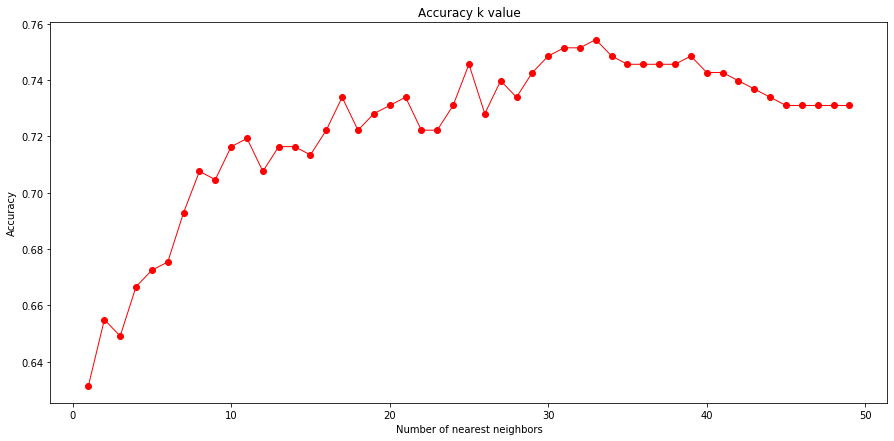

Number of principal components used: 3
Principal component drop count: 10


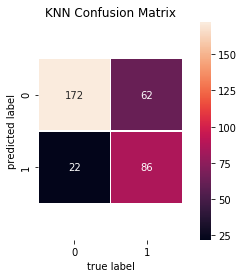

              precision    recall  f1-score   support

           0       0.74      0.89      0.80       194
           1       0.80      0.58      0.67       148

    accuracy                           0.75       342
   macro avg       0.77      0.73      0.74       342
weighted avg       0.76      0.75      0.75       342



In [0]:
acc12, b = knn_optimizer(df_train,df_test,df_train_y['Interest'],df_test_y['Interest'],count=10,show_info=True, criterion='Accuracy', pca=True, category='best',scaler='standard')

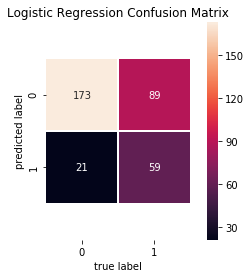

              precision    recall  f1-score   support

           0       0.66      0.89      0.76       194
           1       0.74      0.40      0.52       148

    accuracy                           0.68       342
   macro avg       0.70      0.65      0.64       342
weighted avg       0.69      0.68      0.65       342



In [0]:
# logistic regression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(pca_dat,df_train_y['Interest'])
pred2 = log_reg.predict(pca_dat_test)
cm2=confusion_matrix(true,pred2)
ax3 = sns.heatmap(cm2.T, square=True, annot=True, fmt='d', cbar=True,linewidths=0.5)
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Logistic Regression Confusion Matrix')
plt.show()
print(classification_report(true,pred2))

In [0]:
def pca_linregr(x_train, x_test, y_train, y_test, count, show_plot=False,show_info=False,criterion='accuracy'):
  pca_dat, pca = pcafun(x_train, count)
  pca_dat_test = pcafun(x_test, count, pca_obj=pca)
  lm = LinearRegression()
  lm.fit(pca_dat,y_train)
  pred = np.round(lm.predict(pca_dat_test))
  rsquared = lm.score(pca_dat_test,y_test)
  mse = mean_squared_error(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  if show_info:
    print(f'R squared score: {rsquared}')
    print(f'Mean squared error: {mse}')
    print(f'Number of correct predictions: {sum(y_test==pred.ravel())}')
    print(f'Accuracy: {np.round(accuracy*100,4)}%')
    print(f'Number of principal components used: {x_train.columns.size - count}')
  if show_plot:
    plt.figure(figsize=(20,7))
    plt.scatter(pca_dat_test.index, y_test)
    plt.plot(pca_dat_test.index,pred,color='red',linewidth=1.5,label='Prediction')
    plt.plot(pca_dat_test.index, y_test, 'r--', color='green', linewidth=1.5, alpha=0.5,label='True')
    plt.xlabel('Matches')
    plt.ylabel('Full-time goals')
    plt.legend()
    plt.show()
  if criterion == 'rsquared':
    return rsquared
  elif criterion == 'mse':
    return mse
  else:
    return accuracy

In [0]:
def lr_optimizer(x_train, x_test, y_train, y_test, criterion='accuracy'):
  metrics = []
  pc_count = []
  for i in range(x_train.columns.size):
    a = pca_linregr(x_train, x_test, y_train, y_test, i,criterion=criterion)
    metrics.append(a)
    pc_count.append(i)
  if criterion == 'mse':
    best = np.argmin(metrics)
  else:
    best = np.argmax(metrics)
  b = pca_linregr(x_train, x_test, y_train, y_test,best,show_plot=True,show_info=True,criterion=criterion)
  print(metrics[::-1])
  plt.figure(figsize=(15,7))
  plt.plot([x_train.columns.size - i for i in pc_count],metrics,color='b',linewidth=1,marker='o')
  plt.xlabel('Number of principal components used')
  plt.ylabel(f'{criterion} when this number of PC is used')
  plt.show()
  return b, best

R squared score: 0.5400964087479665
Mean squared error: 1.4941520467836258
Number of correct predictions: 111
Accuracy: 32.4561%
Number of principal components used: 13


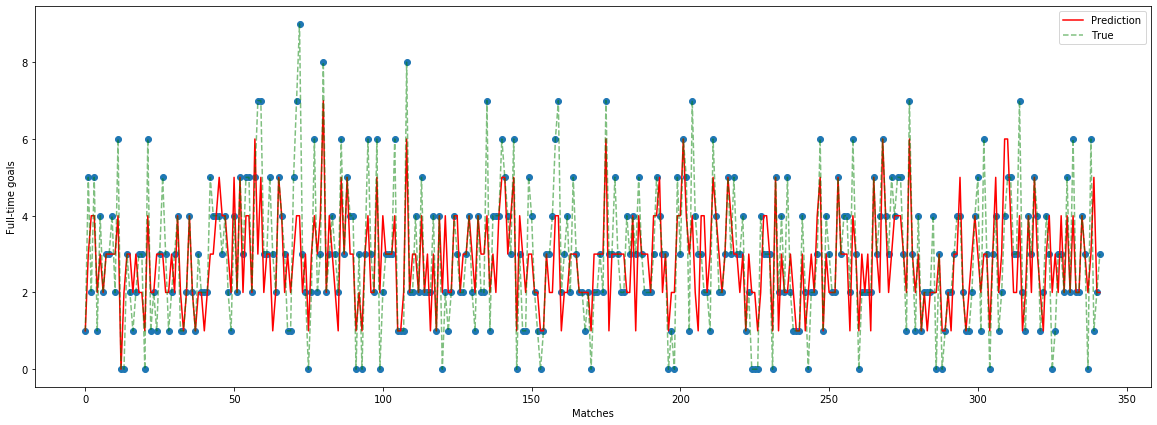

[3.0964912280701755, 3.1491228070175437, 3.210526315789474, 3.307017543859649, 1.5760233918128654, 1.5087719298245614, 1.523391812865497, 1.5350877192982457, 1.5029239766081872, 1.5350877192982457, 1.5350877192982457, 1.5263157894736843, 1.4941520467836258]


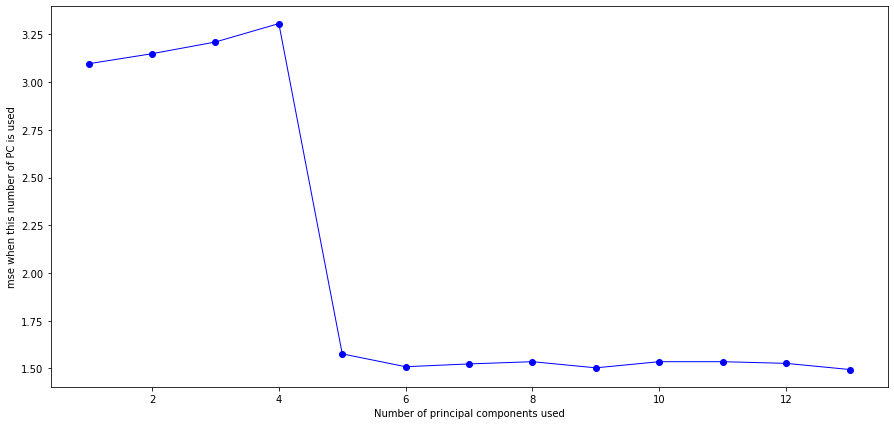

(1.4941520467836258, 0)

In [0]:
lr_optimizer(df_train,df_test,df_train_y['FTG'],df_test_y['FTG'],criterion='mse')

R squared score: 0.5304967028847609
Mean squared error: 1.5350877192982457
Number of correct predictions: 112
Accuracy: 32.7485%
Number of principal components used: 11


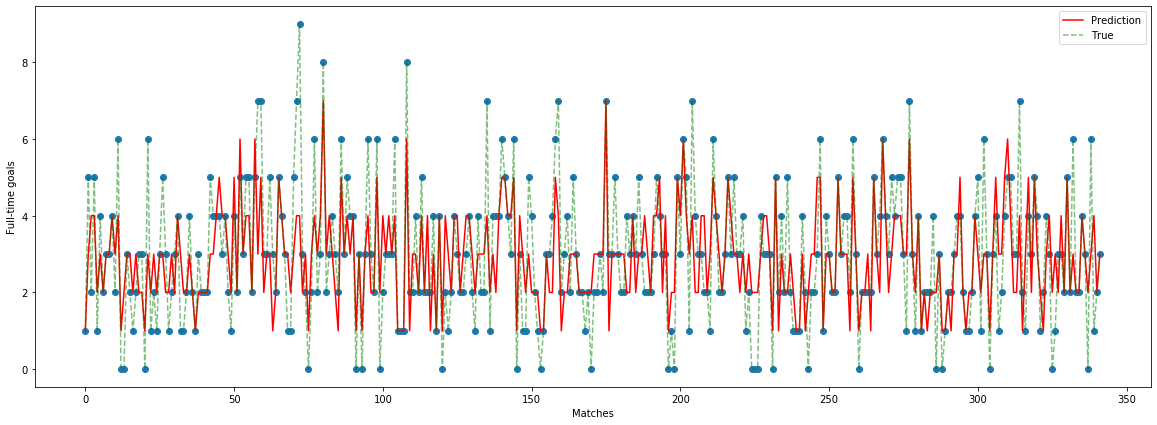

1.5350877192982457

In [0]:
pca_linregr(df_train,df_test,df_train_y['FTG'],df_test_y['FTG'], 2, show_plot=True, show_info=True, criterion='mse')

In [0]:
def regrFTG(label_,scaling=False,kind='minmax'):
  if scaling:
    train = scale(df_train.copy(),kind=kind,return_df=True)
    x_test = scale(df_test.copy(),kind=kind,return_df=True)
    y_train = scale(df_train_y.copy(),kind=kind,return_df=True)
    y_test = scale(df_test_y.copy(),kind=kind,return_df=True)
  else:
    train = df_train.copy()
    x_test = df_test.copy()
    y_train = df_train_y.copy()
    y_test = df_test_y.copy()
  print(train.shape)
  X=np.array(train[label_]).reshape(-1,1)
  y=np.array(df_train_y['FTG']).reshape(-1,1)
  x1=np.array(x_test[label_]).reshape(-1,1)
  testftg=df_test_y['FTG']
  reg1 = LinearRegression()
  reg1.fit(X,y)
  pred=reg1.predict(x1)
  predicted=np.round(pred)
  same=sum(testftg==predicted.ravel())
  print(f'-----{label_}-----')
  print("number of correct predictions "+str(same))
  print(f'Accuracy is: {str(same/342*100)}%')
  print(f'coefficients: {reg1.coef_}')
  print(f'mean squared error: {mean_squared_error(testftg,pred)}')
  plt.scatter(df_test_x.index,testftg)
  plt.plot(df_test_x.index,predicted,color='red')
  plt.xlabel('Matches')
  plt.ylabel('Full-time goals')
  plt.show()


(798, 13)
-----HST-----
number of correct predictions 89
Accuracy is: 26.023391812865498%
coefficients: [[0.18709704]]
mean squared error: 2.683356070015964


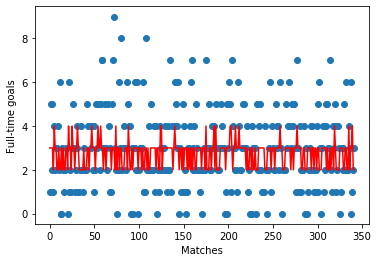

(798, 13)
-----HS-----
number of correct predictions 74
Accuracy is: 21.637426900584796%
coefficients: [[0.02727172]]
mean squared error: 3.0889146799884175


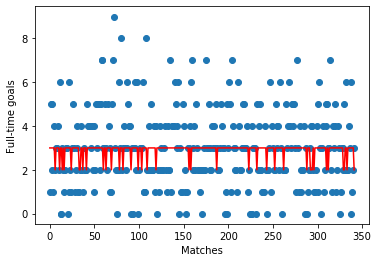

(798, 13)
-----HTHG-----
number of correct predictions 79
Accuracy is: 23.099415204678362%
coefficients: [[0.93553871]]
mean squared error: 2.5219148275458596


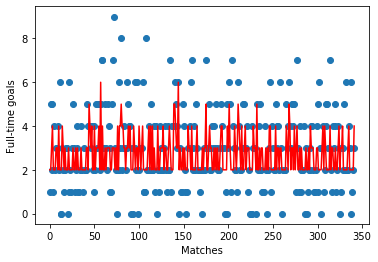

(798, 13)
-----AST-----
number of correct predictions 88
Accuracy is: 25.730994152046783%
coefficients: [[0.21391812]]
mean squared error: 2.936397428235386


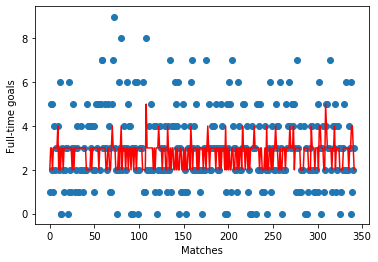

In [0]:
regrFTG('HST')
regrFTG('HS')
regrFTG('HTHG')
regrFTG('AST')